In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import dendrogram, linkage
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

### Load Dataset

In [2]:
dirname = '/Users/Friso/PycharmProjects/Master_Thesis/Project/'

df_ARWU2018 = pd.read_csv(dirname + 'ARWU/data/grid2/ARWURanking_2018_grid.csv')
df_QS2018 = pd.read_csv(dirname + 'QS/data/grid2/qs2019_grid.csv')
df_THE2018 = pd.read_csv(dirname + 'THE/data/grid2/THERanking2019__grid.csv')

### Create dataframes

In [3]:
# merge ARWU with QS
df = pd.merge(df_ARWU2018, df_QS2018, on='GRID_ID', how='left')

# merge df with THE
df = pd.merge(df, df_THE2018, on='GRID_ID', how='left')
df = df[['Name_x', 'Alumni', 'Award', 'HiCi', 'NS', 'PUB', 'PCP', 'Academic_reputation', 'Employer_reputation',
         'Faculty_Student', 'International_Faculty', 'International_Students', 'Citations_x', 'Teaching',
         'Rechearch', 'Citations_y', 'Industry_Income', 'Internationals_Outlook', 'GRID_ID', 'rank', 'Rank', 'WorldRank']]
df = df.dropna()  # drop rows with missing values
print('Remaining number of Universities: {}'.format(df.shape[0]))

# create dataframe with overall rankings
df_ranking = df[['Name_x', 'rank', 'Rank', 'WorldRank']]
df_ranking = df_ranking.rename(columns={"Name_x": 'University', "rank": "THES_Rank", "Rank": "QS_Rank", 'WorldRank': 'ARWU_Rank'})
df_ranking = df_ranking.set_index('University')
df_ranking['THES_Rank'] = df_ranking['THES_Rank'].str.replace('=', '')
df_ranking['QS_Rank'] = df_ranking['QS_Rank'].str.replace('=', '')
for index, row in df_ranking.iterrows():
    THES_Rank = row['THES_Rank'].split('–')
    THES_Rank = [int(x) for x in THES_Rank]
    THES_Rank = np.mean(THES_Rank)
    df_ranking.loc[index, 'THES_Rank'] = THES_Rank
    
    ARWU_Rank = row['ARWU_Rank'].split('-')
    ARWU_Rank = [int(x) for x in ARWU_Rank]
    ARWU_Rank = np.mean(ARWU_Rank)
    df_ranking.loc[index, 'ARWU_Rank'] = ARWU_Rank
            
# create dataframe which only contains data_ranking data
df_data = df[['Name_x', 'Alumni', 'Award', 'HiCi', 'NS', 'PUB', 'PCP', 'Academic_reputation', 'Employer_reputation',
              'Faculty_Student', 'International_Faculty', 'International_Students', 'Citations_x', 'Teaching',
              'Rechearch', 'Citations_y', 'Industry_Income', 'Internationals_Outlook']].copy(deep=True)
df_data = df_data.rename(columns={"Citations_x": 'QS_Citations', "Citations_y": "THES_Citations"})
df_data = df_data.set_index('Name_x')
# display(df_data.head())

Remaining number of Universities: 347


### Correlations

In [4]:
cor = df_data.corr()
cor_unstacked = cor.unstack()
cor_unstacked = cor_unstacked[cor_unstacked != 1].drop_duplicates()
print('\nHighest Correlations:')
display(cor_unstacked.sort_values(ascending=False).head(20))

print('\nOverall Rank Correlations:')
cor3 = df_ranking.astype(float).corr()
display(cor3)

cor2 = df_data[['PUB', 'QS_Citations', 'THES_Citations', 'NS']].copy()
cor2['ARWU_Citations'] = (cor2['PUB'] + cor2['NS']) / 2
cor2 = cor2.drop(['NS', 'PUB'], axis=1)
cor2 = cor2.corr()
print('\nCitation Correlations:')
display(cor2)


Highest Correlations:


Teaching                Rechearch                 0.908515
International_Faculty   Internationals_Outlook    0.862776
Academic_reputation     Rechearch                 0.835538
International_Students  Internationals_Outlook    0.835094
Academic_reputation     Employer_reputation       0.823747
                        Teaching                  0.806869
Alumni                  Award                     0.802493
Award                   NS                        0.769453
HiCi                    NS                        0.762190
NS                      Rechearch                 0.751334
Alumni                  NS                        0.749361
NS                      PCP                       0.744846
                        Teaching                  0.741140
Award                   PCP                       0.741066
PUB                     Academic_reputation       0.720236
Employer_reputation     Rechearch                 0.715021
International_Faculty   International_Students    0.7133


Overall Rank Correlations:


,THES_Rank,QS_Rank,ARWU_Rank
THES_Rank,1.000000,0.700150,0.681733
QS_Rank,0.700150,1.000000,0.628645
ARWU_Rank,0.681733,0.628645,1.000000



Citation Correlations:


,QS_Citations,THES_Citations,ARWU_Citations
QS_Citations,1.000000,0.410404,0.416826
THES_Citations,0.410404,1.000000,0.401934
ARWU_Citations,0.416826,0.401934,1.000000


### Clustering

In [5]:
# K-Means
def doKmeans(X, nclust):
    model = KMeans(nclust)
    model.fit(X)
    clust_labels = model.predict(X)
    cent = model.cluster_centers_
    return (clust_labels, cent)
df_kmeans = df_data.copy()
clust_labels, cent = doKmeans(df_kmeans, 4)
df_kmeans['kmeans']  = clust_labels

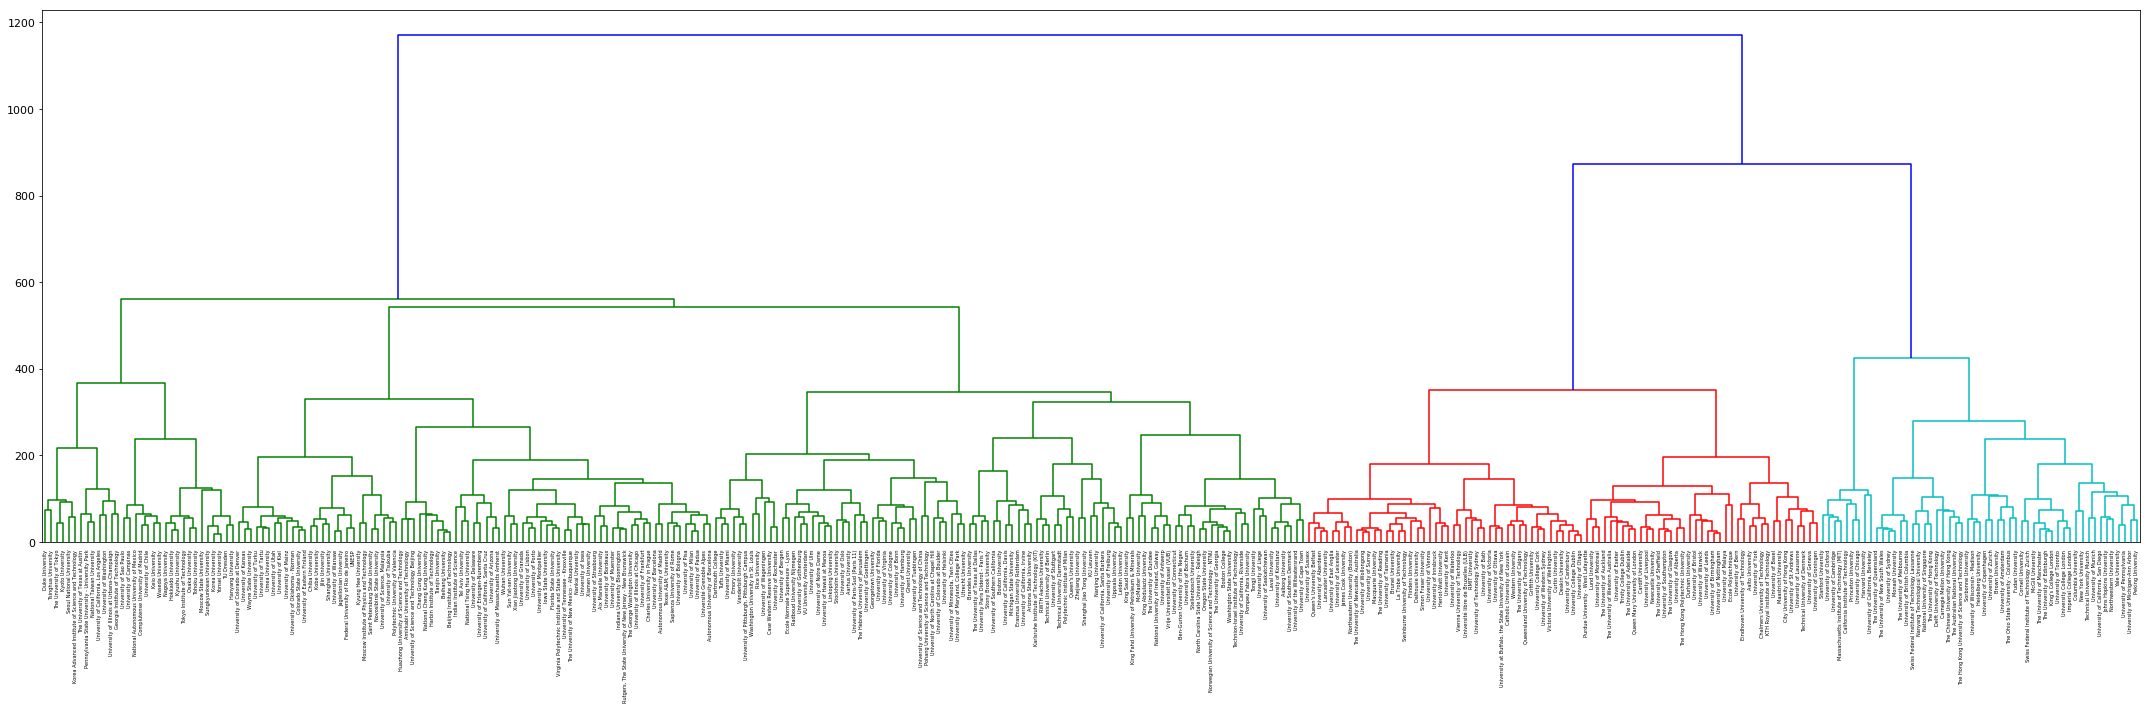

In [6]:
# Hierachical clustering
df_HCluster = df_data.copy()

linked = linkage(df_HCluster, 'ward')

plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(30, 10))
dendrogram(
            linked,
            orientation='top',
            labels=df_HCluster.index.values,
            distance_sort='descending',
            show_leaf_counts=False
          )
plt.tight_layout()
# plt.savefig('test.png', dpi=1000)

cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
model = cluster.fit(df_HCluster)
clust_labels = cluster.fit_predict(df_HCluster)
df_HCluster['HCluster'] = clust_labels

In [7]:
# Calculate PCA for visualisation purposes
df_pca = df_data.copy()

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_pca.values)
df_pca['pca-one'] = pca_result[:,0]
df_pca['pca-two'] = pca_result[:,1]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.41318459 0.21611218]


### Plotly Settings

In [8]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

layout1 = go.Layout(
    hovermode= 'closest',
    title='K-Means Clustering + PCA',
    xaxis=dict(
        showspikes=False,
        autorange=True,
        zeroline=False,
        ticks='',
    ),
    yaxis=dict(
        showspikes=False,
        autorange=True,
        zeroline=False,
        ticks='',
    )
)

layout2 = go.Layout(
    hovermode= 'closest',
    title='Hierachical Clustering + PCA',
    xaxis=dict(
        showspikes=False,
        autorange=True,
        zeroline=False,
        ticks='',
    ),
    yaxis=dict(
        showspikes=False,
        autorange=True,
        zeroline=False,
        ticks='',
    )
)

trace1 = go.Scatter(
    x = df_pca['pca-one'],
    y = df_pca['pca-two'],
    mode = 'markers',
    marker = dict(
        size = 10,
        color = df_kmeans['kmeans'],
        colorscale='Viridis'),
    text = df_pca.index.values,
)

trace2 = go.Scatter(
    x = df_pca['pca-one'],
    y = df_pca['pca-two'],
    mode = 'markers',
    marker = dict(
        size = 10,
        color = df_HCluster['HCluster'],
        colorscale='Viridis'),
    text = df_pca.index.values,
)

In [9]:
data1 = [trace1]
fig = go.Figure(data=data1, layout=layout1)
py.iplot(fig, filename='axes-booleans')

In [10]:
data2 = [trace2]
fig2 = go.Figure(data=data2, layout=layout2)
py.iplot(fig2, filename='axes-booleans2')